In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pydicom
import numpy as np
from PIL import Image, ImageDraw
from tqdm import tqdm
import cv2
import glob
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import torchvision.transforms as transforms
import torchvision.utils as vutils


In [2]:

# Laad de CSV-bestanden
data_dir = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))
label_coords_df = pd.read_csv(os.path.join(data_dir, 'train_label_coordinates.csv'))
series_desc_df = pd.read_csv(os.path.join(data_dir, 'train_series_descriptions.csv'))

# Combineer de gegevens op basis van study_id en series_id
merged_df = label_coords_df.merge(series_desc_df, on=['study_id', 'series_id'])
merged_df = merged_df.merge(train_df, on='study_id')

# Voeg een kolom toe voor de image path
merged_df['image_path'] = merged_df.apply(lambda row: os.path.join(data_dir, 'train_images', str(row['study_id']), str(row['series_id']), f"{row['instance_number']}.dcm"), axis=1)

# Selecteer relevante kolommen voor classificatie (pas deze aan naar je eigen taak)
conditions = [
    'spinal_canal_stenosis_l1_l2', 'spinal_canal_stenosis_l2_l3', 'spinal_canal_stenosis_l3_l4',
    'spinal_canal_stenosis_l4_l5', 'spinal_canal_stenosis_l5_s1',
    'left_neural_foraminal_narrowing_l1_l2', 'left_neural_foraminal_narrowing_l2_l3',
    'left_neural_foraminal_narrowing_l3_l4', 'left_neural_foraminal_narrowing_l4_l5'
]

# Houd alleen de rijen waar alle condities beschikbaar zijn
merged_df = merged_df.dropna(subset=conditions)

In [3]:
# List out all of the Studies we have on patients.
part_1 = os.listdir('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images')
part_1 = list(filter(lambda x: x.find('.DS') == -1, part_1))


df_meta_f = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

p1 = [(x, f"/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{x}") for x in part_1]
meta_obj = { p[0]: { 'folder_path': p[1], 
                    'SeriesInstanceUIDs': [] 
                   } 
            for p in p1 }
for m in meta_obj:
    meta_obj[m]['SeriesInstanceUIDs'] = list(
        filter(lambda x: x.find('.DS') == -1, 
               os.listdir(meta_obj[m]['folder_path'])
              )
    )


# grabs the correspoding series descriptions
for k in tqdm(meta_obj):
    for s in meta_obj[k]['SeriesInstanceUIDs']:
        if 'SeriesDescriptions' not in meta_obj[k]:
            meta_obj[k]['SeriesDescriptions'] = []
        try:
            meta_obj[k]['SeriesDescriptions'].append(
                df_meta_f[(df_meta_f['study_id'] == int(k)) & 
                (df_meta_f['series_id'] == int(s))]['series_description'].iloc[0])
        except:
            print("Failed on", s, k)

meta_obj[list(meta_obj.keys())[1]]
patient = train_df.iloc[1]
ptobj = meta_obj[str(patient['study_id'])]

100%|██████████| 1975/1975 [00:03<00:00, 629.56it/s]


In [4]:
meta_obj[list(meta_obj.keys())[1]]

{'folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1972129014',
 'SeriesInstanceUIDs': ['2898623075', '3324327485', '3203550406'],
 'SeriesDescriptions': ['Sagittal T2/STIR', 'Axial T2', 'Sagittal T1']}

In [5]:
patient = train_df.iloc[1]

In [6]:
df_coor = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')

In [7]:
ptobj = meta_obj[str(patient['study_id'])]

In [8]:
im_list_dcm = {}
for idx, i in enumerate(ptobj['SeriesInstanceUIDs']):
    im_list_dcm[i] = {'images': [], 'description': ptobj['SeriesDescriptions'][idx]}
    images = glob.glob(f"{ptobj['folder_path']}/{ptobj['SeriesInstanceUIDs'][idx]}/*.dcm")
    for j in sorted(images, key=lambda x: int(x.split('/')[-1].replace('.dcm', ''))):
        im_list_dcm[i]['images'].append({
            'SOPInstanceUID': j.split('/')[-1].replace('.dcm', ''), 
            'dicom': pydicom.dcmread(j) })

In [9]:
def display_coor_on_img(c, i, title):
    center_coordinates = (int(c['x']), int(c['y']))
    radius = 10
    color = (255, 0, 0)  # Red color in BGR
    thickness = 2
    IMG = i['dicom'].pixel_array
    IMG_normalized = cv2.normalize(IMG, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    
    IMG_with_circle = cv2.circle(IMG_normalized.copy(), center_coordinates, radius, color, thickness)
    
    # Convert the image from BGR to RGB for correct color display in matplotlib
    IMG_with_circle = cv2.cvtColor(IMG_with_circle, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(IMG_with_circle)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.title(title)
    plt.show()

In [10]:
coor_entries = df_coor[df_coor['study_id'] == int(patient['study_id'])]

Only showing severe cases for this patient


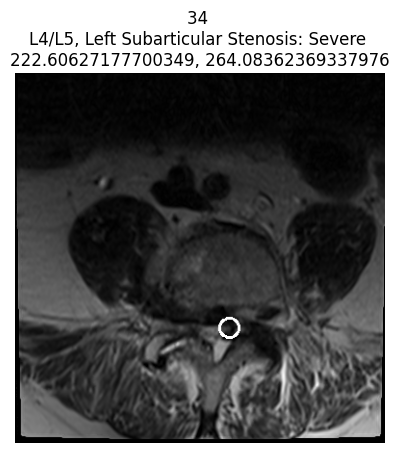

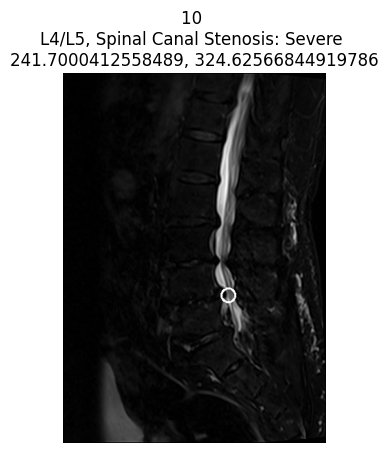

In [11]:
print("Only showing severe cases for this patient")
for idc, c in coor_entries.iterrows():
    for i in im_list_dcm[str(c['series_id'])]['images']:
        if int(i['SOPInstanceUID']) == int(c['instance_number']):
            try:
                patient_severity = patient[
                    f"{c['condition'].lower().replace(' ', '_')}_{c['level'].lower().replace('/', '_')}"
                ]
            except Exception as e:
                patient_severity = "unknown severity"
            title = f"{i['SOPInstanceUID']} \n{c['level']}, {c['condition']}: {patient_severity} \n{c['x']}, {c['y']}"
            if patient_severity == 'Severe':
                display_coor_on_img(c, i, title)

In [12]:
!pip install torchio open3d timm_3d spacecutter skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.4/174.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.8/626.8 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 92.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 74.4 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: jupyterlab-widgets
    Found existing

In [13]:
import os
import gc
import sys
from PIL import Image
import cv2
import math, random
import numpy as np
import pandas as pd
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from collections import OrderedDict

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW

import timm
from transformers import get_cosine_schedule_with_warmup

import albumentations as A

from sklearn.model_selection import KFold

import re

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [14]:
def imread_and_imwirte(src_path, dst_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    img = cv2.resize(image, (512, 512),interpolation=cv2.INTER_CUBIC)
    assert img.shape==(512,512)
    cv2.imwrite(dst_path, img)

In [17]:
rd = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
df = pd.read_csv(f'{rd}/train_series_descriptions.csv')
st_ids = df['study_id'].unique()
dfc = pd.read_csv(f'{rd}/train_label_coordinates.csv')
desc = list(df['series_description'].unique())

In [19]:
def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]

In [20]:
for idx, si in enumerate(tqdm(st_ids, total=len(st_ids))):
    pdf = df[df['study_id']==si]
    for ds in desc:
        ds_ = ds.replace('/', '_')
        pdf_ = pdf[pdf['series_description']==ds]
        os.makedirs(f'cvt_png/{si}/{ds_}', exist_ok=True)
        allimgs = []
        for i, row in pdf_.iterrows():
            pimgs = glob.glob(f'{rd}/train_images/{row["study_id"]}/{row["series_id"]}/*.dcm')
            pimgs = sorted(pimgs, key=natural_keys)
            allimgs.extend(pimgs)
            
        if len(allimgs)==0:
            print(si, ds, 'has no images')
            continue

        if ds == 'Axial T2':
            for j, impath in enumerate(allimgs):
                dst = f'cvt_png/{si}/{ds}/{j:03d}.png'
                imread_and_imwirte(impath, dst)
                
        elif ds == 'Sagittal T2/STIR':
            
            step = len(allimgs) / 10.0
            st = len(allimgs)/2.0 - 4.0*step
            end = len(allimgs)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                dst = f'cvt_png/{si}/{ds_}/{j:03d}.png'
                ind2 = max(0, int((i-0.5001).round()))
                imread_and_imwirte(allimgs[ind2], dst)
                
            assert len(glob.glob(f'cvt_png/{si}/{ds_}/*.png'))==10
                
        elif ds == 'Sagittal T1':
            step = len(allimgs) / 10.0
            st = len(allimgs)/2.0 - 4.0*step
            end = len(allimgs)+0.0001
            for j, i in enumerate(np.arange(st, end, step)):
                dst = f'cvt_png/{si}/{ds}/{j:03d}.png'
                ind2 = max(0, int((i-0.5001).round()))
                imread_and_imwirte(allimgs[ind2], dst)
                
            assert len(glob.glob(f'cvt_png/{si}/{ds}/*.png'))==10

 57%|█████▋    | 1126/1975 [29:25<18:31,  1.31s/it] 

2492114990 Sagittal T1 has no images


 64%|██████▍   | 1272/1975 [32:59<15:23,  1.31s/it]

2780132468 Sagittal T1 has no images


 70%|██████▉   | 1378/1975 [35:46<12:44,  1.28s/it]

3008676218 Sagittal T2/STIR has no images


100%|██████████| 1975/1975 [51:08<00:00,  1.55s/it]


In [21]:
NOT_DEBUG = True # True -> run naormally, False -> debug mode, with lesser computing cost

OUTPUT_DIR = f'rsna24-results'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
N_WORKERS = os.cpu_count() 
USE_AMP = True # can change True if using T4 or newer than Ampere
SEED = 8620

IMG_SIZE = [512, 512]
IN_CHANS = 30
N_LABELS = 25
N_CLASSES = 3 * N_LABELS

AUG_PROB = 0.75

N_FOLDS = 5 if NOT_DEBUG else 2
EPOCHS = 20 if NOT_DEBUG else 2
MODEL_NAME = "tf_efficientnet_b3.ns_jft_in1k" if NOT_DEBUG else "tf_efficientnet_b0.ns_jft_in1k"

GRAD_ACC = 2
TGT_BATCH_SIZE = 32
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
MAX_GRAD_NORM = None
EARLY_STOPPING_EPOCH = 3

LR = 2e-4 * TGT_BATCH_SIZE / 32
WD = 1e-2
AUG = True


In [22]:
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [23]:
def set_random_seed(seed: int = 8620, deterministic: bool = False):
    """Set seeds"""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = deterministic  # type: ignore


In [24]:
df = pd.read_csv(f'{rd}/train.csv')
df.head()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
1,4646740,Normal/Mild,Normal/Mild,Moderate,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,Normal/Mild
2,7143189,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
3,8785691,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild
4,10728036,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Normal/Mild


In [25]:
df = df.fillna(-100)

In [26]:
label2id = {'Normal/Mild': 0, 'Moderate':1, 'Severe':2}
df = df.replace(label2id)
df.head()

/tmp/ipykernel_36/1901592955.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(label2id)


,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
0,4003253,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,4646740,0,0,1,2,0,0,0,0,1,...,0,0,0,2,0,0,1,1,1,0
2,7143189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,8785691,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,10728036,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [27]:
CONDITIONS = [
    'Spinal Canal Stenosis', 
    'Left Neural Foraminal Narrowing', 
    'Right Neural Foraminal Narrowing',
    'Left Subarticular Stenosis',
    'Right Subarticular Stenosis'
]

LEVELS = [
    'L1/L2',
    'L2/L3',
    'L3/L4',
    'L4/L5',
    'L5/S1',
]

In [28]:
class RSNA24Dataset(Dataset):
    def __init__(self, df, phase='train', transform=None):
        self.df = df
        self.transform = transform
        self.phase = phase
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x = np.zeros((512, 512, IN_CHANS), dtype=np.uint8)
        t = self.df.iloc[idx]
        st_id = int(t['study_id'])
        label = t[1:].values.astype(np.int64)
        
        # Sagittal T1
        for i in range(0, 10, 1):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T1/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T1')
                pass
            
        # Sagittal T2/STIR
        for i in range(0, 10, 1):
            try:
                p = f'./cvt_png/{st_id}/Sagittal T2_STIR/{i:03d}.png'
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+10] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass
            
        # Axial T2
        axt2 = glob.glob(f'./cvt_png/{st_id}/Axial T2/*.png')
        axt2 = sorted(axt2)
    
        step = len(axt2) / 10.0
        st = len(axt2)/2.0 - 4.0*step
        end = len(axt2)+0.0001
                
        for i, j in enumerate(np.arange(st, end, step)):
            try:
                p = axt2[max(0, int((j-0.5001).round()))]
                img = Image.open(p).convert('L')
                img = np.array(img)
                x[..., i+20] = img.astype(np.uint8)
            except:
                print(f'failed to load on {st_id}, Sagittal T2/STIR')
                pass  
            
        assert np.sum(x)>0
            
        if self.transform is not None:
            x = self.transform(image=x)['image']

        x = x.transpose(2, 0, 1)
                
        return x, label

In [29]:
transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=AUG_PROB),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=AUG_PROB),

    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.),
        A.ElasticTransform(alpha=3),
    ], p=AUG_PROB),

    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=AUG_PROB),
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.CoarseDropout(max_holes=16, max_height=64, max_width=64, min_holes=1, min_height=8, min_width=8, p=AUG_PROB),    
    A.Normalize(mean=0.5, std=0.5)
])

transforms_val = A.Compose([
    A.Resize(IMG_SIZE[0], IMG_SIZE[1]),
    A.Normalize(mean=0.5, std=0.5)
])

if not NOT_DEBUG or not AUG:
    transforms_train = transforms_val

/opt/conda/lib/python3.10/site-packages/pydantic/main.py:193: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


In [30]:
tmp_ds = RSNA24Dataset(df, phase='train', transform=transforms_train)
tmp_dl = DataLoader(
            tmp_ds,
            batch_size=1,
            shuffle=False,
            pin_memory=True,
            drop_last=False,
            num_workers=0
            )


x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.8667) tensor(-0.8402) tensor(0.3236)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


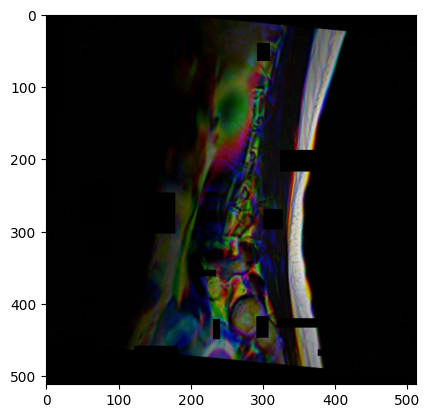

y stat: (512, 512, 3) 0.0 0.9176471 0.063653015 0.14028433

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.6546) tensor(0.3384)
tensor([[0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 1,
         0]]) torch.Size([1, 25])


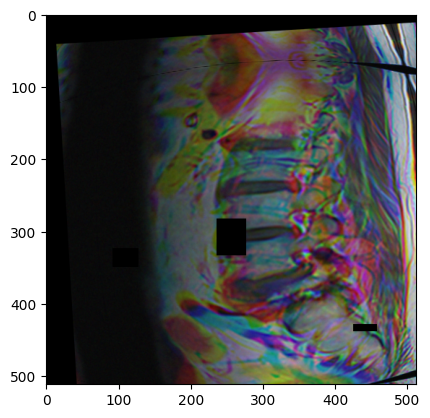

y stat: (512, 512, 3) 0.0 0.9843137 0.22163321 0.18681197

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.7106) tensor(0.4356)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


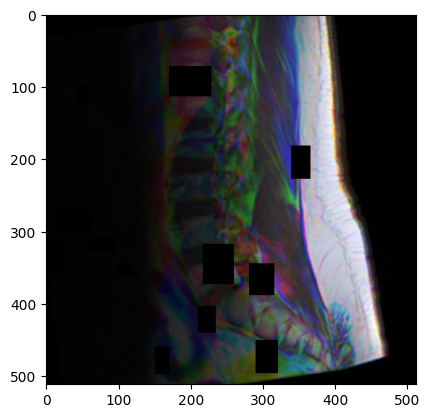

y stat: (512, 512, 3) 0.0 1.0 0.15884344 0.23235874

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(1.) tensor(-0.6102) tensor(0.4625)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]) torch.Size([1, 25])


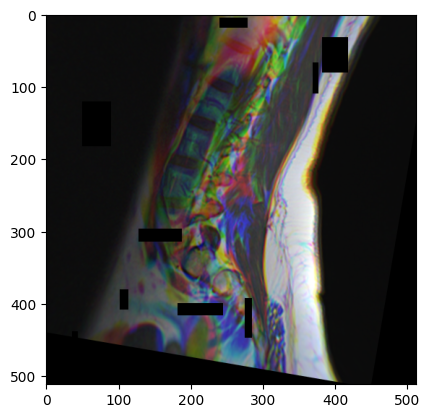

y stat: (512, 512, 3) 0.0 1.0 0.18958646 0.22380526

x stat: torch.Size([1, 30, 512, 512]) tensor(-1.) tensor(0.9922) tensor(-0.4744) tensor(0.3903)
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0]]) torch.Size([1, 25])


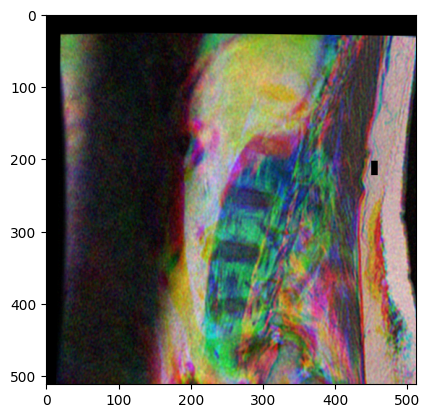

y stat: (512, 512, 3) 0.0 0.99215686 0.3128782 0.2457098



In [31]:

for i, (x, t) in enumerate(tmp_dl):
    if i==5:break
    print('x stat:', x.shape, x.min(), x.max(),x.mean(), x.std())
    print(t, t.shape)
    y = x.numpy().transpose(0,2,3,1)[0,...,:3]
    y = (y + 1) / 2
    plt.imshow(y)
    plt.show()
    print('y stat:', y.shape, y.min(), y.max(),y.mean(), y.std())
    print()
plt.close()
del tmp_ds, tmp_dl

In [32]:
class RSNA24Model(nn.Module):
    def __init__(self, model_name, in_c=30, n_classes=75, pretrained=True, features_only=False):
        super().__init__()
        self.model = timm.create_model(
                                    model_name,
                                    pretrained=pretrained, 
                                    features_only=features_only,
                                    in_chans=in_c,
                                    num_classes=n_classes,
                                    global_pool='avg'
                                    )
    
    def forward(self, x):
        y = self.model(x)
        return y

In [33]:
m = RSNA24Model(MODEL_NAME, in_c=IN_CHANS, n_classes=N_CLASSES, pretrained=False)
i = torch.randn(2, IN_CHANS, 512, 512)
out = m(i)
for o in out:
    print(o.shape, o.min(), o.max())

torch.Size([75]) tensor(-0.9899, grad_fn=<MinBackward1>) tensor(0.8636, grad_fn=<MaxBackward1>)
torch.Size([75]) tensor(-1.2906, grad_fn=<MinBackward1>) tensor(1.0396, grad_fn=<MaxBackward1>)


In [34]:
del m, i, out

In [ ]:
from collections import OrderedDict
import math
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import AdamW
from transformers import get_cosine_schedule_with_warmup

# Autocast and GradScaler initialization
autocast = torch.amp.autocast(device, enabled=USE_AMP, dtype=torch.half)
scaler = torch.amp.GradScaler(enabled=USE_AMP, init_scale=4096)

# Stratified K-Fold
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(df)))):
    print('#'*30)
    print(f'Start fold {fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))

    # Data preparation
    df_train = df.iloc[trn_idx]
    df_valid = df.iloc[val_idx]

    train_ds = RSNA24Dataset(df_train, phase='train', transform=transforms_train)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, drop_last=True, num_workers=N_WORKERS)

    valid_ds = RSNA24Dataset(df_valid, phase='valid', transform=transforms_val)
    valid_dl = DataLoader(valid_ds, batch_size=BATCH_SIZE * 2, shuffle=False, pin_memory=True, drop_last=False, num_workers=N_WORKERS)

    # Model, optimizer, scheduler
    model = RSNA24Model(MODEL_NAME, IN_CHANS, N_CLASSES, pretrained=True)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)

    warmup_steps = EPOCHS / 10 * len(train_dl) // GRAD_ACC
    num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
    num_cycles = 0.475
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_total_steps, num_cycles=num_cycles)

    # Loss function with weights
    weights = torch.tensor([1.0, 2.0, 4.0])
    criterion = nn.CrossEntropyLoss(weight=weights.to(device))

    best_loss = 1.2
    best_wll = 1.2
    es_step = 0

    def compute_loss(y, t, criterion):
        """Helper function to compute loss over columns."""
        loss = 0
        for col in range(N_LABELS):
            pred = y[:, col * 3: col * 3 + 3]
            gt = t[:, col]
            loss += criterion(pred, gt) / N_LABELS
        return loss

    # Training and validation loop
    for epoch in range(1, EPOCHS + 1):
        print(f'Start epoch {epoch}')

        # Training phase
        model.train()
        total_loss = 0
        optimizer.zero_grad(set_to_none=True)

        with tqdm(train_dl, leave=True) as pbar:
            for idx, (x, t) in enumerate(pbar):
                x, t = x.to(device), t.to(device)

                with autocast:
                    y = model(x)
                    loss = compute_loss(y, t, criterion)

                    total_loss += loss.item()
                    if GRAD_ACC > 1:
                        loss /= GRAD_ACC

                # Handle NaN loss
                if not math.isfinite(loss):
                    print(f"Loss is {loss}, stopping training")
                    sys.exit(1)

                pbar.set_postfix(OrderedDict(loss=f'{loss.item() * GRAD_ACC:.6f}', lr=f'{optimizer.param_groups[0]["lr"]:.3e}'))
                scaler.scale(loss).backward()

                torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM or 1e9)

                if (idx + 1) % GRAD_ACC == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad(set_to_none=True)

                    if scheduler is not None:
                        scheduler.step()

        train_loss = total_loss / len(train_dl)
        print(f'train_loss: {train_loss:.6f}')

        # Validation phase
        model.eval()
        total_loss = 0
        y_preds = []
        labels = []

        with tqdm(valid_dl, leave=True) as pbar:
            with torch.no_grad():
                for idx, (x, t) in enumerate(pbar):
                    x, t = x.to(device), t.to(device)

                    with autocast:
                        y = model(x)
                        loss = compute_loss(y, t, criterion)
                        total_loss += loss.item()

                        # Collect predictions and labels for evaluation
                        for col in range(N_LABELS):
                            pred = y[:, col * 3:col * 3 + 3]
                            y_preds.append(pred.float().cpu())
                            labels.append(t[:, col].cpu())

        val_loss = total_loss / len(valid_dl)
        y_preds = torch.cat(y_preds, dim=0)
        labels = torch.cat(labels)
        val_wll = nn.CrossEntropyLoss()(y_preds, labels)

        print(f'val_loss: {val_loss:.6f}, val_wll: {val_wll:.6f}')

        # Early stopping and saving the best model
        if val_loss < best_loss or val_wll < best_wll:
            es_step = 0

            if val_loss < best_loss:
                print(f'Epoch: {epoch}, best loss updated from {best_loss:.6f} to {val_loss:.6f}')
                best_loss = val_loss

            if val_wll < best_wll:
                print(f'Epoch: {epoch}, best wll_metric updated from {best_wll:.6f} to {val_wll:.6f}')
                best_wll = val_wll
                torch.save(model.state_dict(), f'{OUTPUT_DIR}/best_wll_model_fold-{fold}.pt')

        else:
            es_step += 1
            if es_step >= EARLY_STOPPING_EPOCH:
                print('Early stopping')
                break


##############################
start fold0
##############################
1580 395


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

start epoch 1


 54%|█████▍    | 53/98 [03:15<03:48,  5.08s/it, loss=1.006037, lr=5.306e-05]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 61%|██████    | 60/98 [03:28<01:14,  1.95s/it, loss=0.909939, lr=5.918e-05]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 90%|████████▉ | 88/98 [05:14<00:19,  1.95s/it, loss=0.758814, lr=8.776e-05]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [05:41<00:00,  3.48s/it, loss=0.790269, lr=9.796e-05]


train_loss:0.996259


100%|██████████| 13/13 [01:16<00:00,  5.86s/it]


val_loss:0.823810, val_wll:0.881849
epoch:1, best loss updated from 1.200000 to 0.823810
epoch:1, best wll_metric updated from 1.200000 to 0.881849
start epoch 2


  4%|▍         | 4/98 [00:13<03:23,  2.16s/it, loss=0.893817, lr=1.020e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 37%|███▋      | 36/98 [01:45<01:57,  1.90s/it, loss=0.987178, lr=1.347e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 53%|█████▎    | 52/98 [02:28<01:19,  1.73s/it, loss=0.703727, lr=1.510e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:39<00:00,  2.85s/it, loss=0.751667, lr=1.980e-04]


train_loss:0.784193


100%|██████████| 13/13 [01:40<00:00,  7.71s/it]


val_loss:0.774820, val_wll:0.827198
epoch:2, best loss updated from 0.823810 to 0.774820
epoch:2, best wll_metric updated from 0.881849 to 0.827198
start epoch 3


 24%|██▍       | 24/98 [01:08<02:12,  1.79s/it, loss=0.703168, lr=1.999e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 49%|████▉     | 48/98 [02:21<01:40,  2.02s/it, loss=0.663803, lr=1.997e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 62%|██████▏   | 61/98 [03:09<02:59,  4.84s/it, loss=0.713948, lr=1.995e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 63%|██████▎   | 62/98 [03:09<02:10,  3.63s/it, loss=0.713948, lr=1.995e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:54<00:00,  3.01s/it, loss=0.859040, lr=1.987e-04]


train_loss:0.738854


100%|██████████| 13/13 [01:46<00:00,  8.21s/it]


val_loss:0.728822, val_wll:0.792878
epoch:3, best loss updated from 0.774820 to 0.728822
epoch:3, best wll_metric updated from 0.827198 to 0.792878
start epoch 4


  4%|▍         | 4/98 [00:12<03:05,  1.98s/it, loss=0.747154, lr=1.986e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 58%|█████▊    | 57/98 [02:57<02:52,  4.21s/it, loss=0.600160, lr=1.966e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 58%|█████▊    | 57/98 [02:57<02:52,  4.21s/it, loss=0.681796, lr=1.966e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 59%|█████▉    | 58/98 [02:57<02:07,  3.18s/it, loss=0.681796, lr=1.966e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIRfailed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:51<00:00,  2.98s/it, loss=0.772352, lr=1.947e-04]


train_loss:0.705830


100%|██████████| 13/13 [02:01<00:00,  9.35s/it]


val_loss:0.695643, val_wll:0.755408
epoch:4, best loss updated from 0.728822 to 0.695643
epoch:4, best wll_metric updated from 0.792878 to 0.755408
start epoch 5


  0%|          | 0/98 [00:00<?, ?it/s]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 90%|████████▉ | 88/98 [04:34<00:26,  2.68s/it, loss=0.703478, lr=1.888e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:58<00:00,  3.05s/it, loss=0.652368, lr=1.880e-04]


train_loss:0.672815


100%|██████████| 13/13 [02:00<00:00,  9.26s/it]


val_loss:0.704305, val_wll:0.767150
start epoch 6


 50%|█████     | 49/98 [02:34<05:18,  6.50s/it, loss=0.539183, lr=1.837e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1

 50%|█████     | 49/98 [02:34<05:18,  6.50s/it, loss=0.793200, lr=1.837e-04]


failed to load on 2780132468, Sagittal T1


 61%|██████    | 60/98 [02:59<01:13,  1.94s/it, loss=0.619845, lr=1.828e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 95%|█████████▍| 93/98 [04:41<00:17,  3.51s/it, loss=0.695119, lr=1.794e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:48<00:00,  2.94s/it, loss=0.595803, lr=1.790e-04]


train_loss:0.656246


100%|██████████| 13/13 [01:40<00:00,  7.75s/it]


val_loss:0.677471, val_wll:0.731803
epoch:6, best loss updated from 0.695643 to 0.677471
epoch:6, best wll_metric updated from 0.755408 to 0.731803
start epoch 7


 44%|████▍     | 43/98 [02:06<02:12,  2.41s/it, loss=0.609457, lr=1.742e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 61%|██████    | 60/98 [02:56<01:12,  1.90s/it, loss=0.647032, lr=1.724e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 69%|██████▉   | 68/98 [03:23<00:57,  1.92s/it, loss=0.651718, lr=1.714e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [05:00<00:00,  3.06s/it, loss=0.542177, lr=1.678e-04]


train_loss:0.628754


100%|██████████| 13/13 [01:40<00:00,  7.75s/it]


val_loss:0.663005, val_wll:0.717566
epoch:7, best loss updated from 0.677471 to 0.663005
epoch:7, best wll_metric updated from 0.731803 to 0.717566
start epoch 8


 65%|██████▌   | 64/98 [03:07<01:00,  1.77s/it, loss=0.643212, lr=1.595e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 78%|███████▊  | 76/98 [03:39<00:35,  1.63s/it, loss=0.593537, lr=1.578e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 95%|█████████▍| 93/98 [04:30<00:18,  3.67s/it, loss=0.582516, lr=1.553e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:37<00:00,  2.84s/it, loss=0.653743, lr=1.547e-04]


train_loss:0.614745


100%|██████████| 13/13 [01:54<00:00,  8.84s/it]


val_loss:0.657226, val_wll:0.710566
epoch:8, best loss updated from 0.663005 to 0.657226
epoch:8, best wll_metric updated from 0.717566 to 0.710566
start epoch 9


 12%|█▏        | 12/98 [00:34<02:42,  1.89s/it, loss=0.674497, lr=1.530e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 74%|███████▍  | 73/98 [03:27<00:50,  2.02s/it, loss=0.594893, lr=1.439e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 83%|████████▎ | 81/98 [03:51<00:38,  2.27s/it, loss=0.592466, lr=1.426e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:38<00:00,  2.84s/it, loss=0.694658, lr=1.402e-04]


train_loss:0.590733


100%|██████████| 13/13 [01:40<00:00,  7.76s/it]


val_loss:0.661531, val_wll:0.714670
start epoch 10


 41%|████      | 40/98 [01:53<01:51,  1.93s/it, loss=0.557614, lr=1.339e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 45%|████▍     | 44/98 [02:04<01:40,  1.86s/it, loss=0.494657, lr=1.333e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 49%|████▉     | 48/98 [02:16<01:35,  1.92s/it, loss=0.580798, lr=1.326e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:37<00:00,  2.83s/it, loss=0.592117, lr=1.245e-04]


train_loss:0.586375


100%|██████████| 13/13 [01:36<00:00,  7.46s/it]


val_loss:0.660375, val_wll:0.714592
start epoch 11


 10%|█         | 10/98 [00:32<04:31,  3.09s/it, loss=0.550572, lr=1.229e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 10%|█         | 10/98 [00:33<04:31,  3.09s/it, loss=0.611436, lr=1.225e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1

 11%|█         | 11/98 [00:33<03:12,  2.21s/it, loss=0.611436, lr=1.225e-04]


failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


 50%|█████     | 49/98 [02:14<02:05,  2.55s/it, loss=0.495891, lr=1.162e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 88%|████████▊ | 86/98 [04:00<00:38,  3.25s/it, loss=0.513430, lr=1.102e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:30<00:00,  2.76s/it, loss=0.457976, lr=1.082e-04]


train_loss:0.563731


100%|██████████| 13/13 [01:47<00:00,  8.24s/it]


val_loss:0.675594, val_wll:0.732462
early stopping
##############################
start fold1
##############################
1580 395
start epoch 1


 55%|█████▌    | 54/98 [02:29<01:53,  2.59s/it, loss=0.993594, lr=5.306e-05]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:22<00:00,  2.68s/it, loss=0.814530, lr=9.796e-05]


train_loss:0.981931


 31%|███       | 4/13 [01:03<01:19,  8.85s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:22<00:20,  4.11s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:33<00:00,  7.17s/it]


val_loss:0.832428, val_wll:0.888510
epoch:1, best loss updated from 1.200000 to 0.832428
epoch:1, best wll_metric updated from 1.200000 to 0.888510
start epoch 2


 88%|████████▊ | 86/98 [04:03<00:39,  3.31s/it, loss=0.876288, lr=1.857e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:32<00:00,  2.78s/it, loss=0.859417, lr=1.980e-04]


train_loss:0.777570


 31%|███       | 4/13 [01:23<01:42, 11.41s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:42<00:22,  4.50s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:54<00:00,  8.79s/it]


val_loss:0.760868, val_wll:0.818483
epoch:2, best loss updated from 0.832428 to 0.760868
epoch:2, best wll_metric updated from 0.888510 to 0.818483
start epoch 3


 98%|█████████▊| 96/98 [04:22<00:04,  2.26s/it, loss=0.567038, lr=1.987e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:27<00:00,  2.73s/it, loss=0.759888, lr=1.987e-04]


train_loss:0.728700


 31%|███       | 4/13 [01:15<01:33, 10.38s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:32<00:22,  4.45s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:43<00:00,  7.99s/it]


val_loss:0.728859, val_wll:0.783617
epoch:3, best loss updated from 0.760868 to 0.728859
epoch:3, best wll_metric updated from 0.818483 to 0.783617
start epoch 4


 93%|█████████▎| 91/98 [04:17<00:15,  2.17s/it, loss=0.674607, lr=1.950e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:33<00:00,  2.79s/it, loss=0.565760, lr=1.947e-04]


train_loss:0.696481


 31%|███       | 4/13 [01:18<01:39, 11.04s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:39<00:25,  5.06s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:51<00:00,  8.59s/it]


val_loss:0.750943, val_wll:0.817972
start epoch 5


  5%|▌         | 5/98 [00:21<06:27,  4.16s/it, loss=0.591892, lr=1.943e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:26<00:00,  2.72s/it, loss=0.505686, lr=1.880e-04]


train_loss:0.669001


 31%|███       | 4/13 [01:21<01:41, 11.29s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:43<00:25,  5.02s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:53<00:00,  8.76s/it]


val_loss:0.696723, val_wll:0.751406
epoch:5, best loss updated from 0.728859 to 0.696723
epoch:5, best wll_metric updated from 0.783617 to 0.751406
start epoch 6


 89%|████████▉ | 87/98 [03:57<00:25,  2.27s/it, loss=0.677899, lr=1.800e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:27<00:00,  2.73s/it, loss=0.631304, lr=1.790e-04]


train_loss:0.639370


 38%|███▊      | 5/13 [00:48<00:48,  6.12s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 54%|█████▍    | 7/13 [00:54<00:25,  4.17s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:09<00:00,  5.33s/it]


val_loss:0.687299, val_wll:0.739085
epoch:6, best loss updated from 0.696723 to 0.687299
epoch:6, best wll_metric updated from 0.751406 to 0.739085
start epoch 7


 80%|███████▉  | 78/98 [03:37<00:47,  2.40s/it, loss=0.656175, lr=1.703e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:31<00:00,  2.77s/it, loss=0.613880, lr=1.678e-04]


train_loss:0.620189


 31%|███       | 4/13 [01:23<01:44, 11.62s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 38%|███▊      | 5/13 [01:36<01:37, 12.19s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:53<00:00,  8.69s/it]


val_loss:0.686569, val_wll:0.736838
epoch:7, best loss updated from 0.687299 to 0.686569
epoch:7, best wll_metric updated from 0.739085 to 0.736838
start epoch 8


 73%|███████▎  | 72/98 [03:24<00:47,  1.83s/it, loss=0.610416, lr=1.584e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1failed to load on 2492114990, Sagittal T1

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:37<00:00,  2.84s/it, loss=0.671740, lr=1.547e-04]


train_loss:0.608786


 31%|███       | 4/13 [01:19<01:40, 11.12s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 46%|████▌     | 6/13 [01:34<01:00,  8.60s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:48<00:00,  8.35s/it]


val_loss:0.696821, val_wll:0.748976
start epoch 9


 65%|██████▌   | 64/98 [02:57<00:55,  1.63s/it, loss=0.543678, lr=1.454e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:29<00:00,  2.75s/it, loss=0.547280, lr=1.402e-04]


train_loss:0.580048


 31%|███       | 4/13 [01:03<01:18,  8.73s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:22<00:19,  3.95s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:35<00:00,  7.37s/it]


val_loss:0.709976, val_wll:0.765801
start epoch 10


 45%|████▍     | 44/98 [02:02<02:10,  2.41s/it, loss=0.634620, lr=1.333e-04]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:30<00:00,  2.76s/it, loss=0.527663, lr=1.245e-04]


train_loss:0.565081


 31%|███       | 4/13 [00:48<01:00,  6.75s/it]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 62%|██████▏   | 8/13 [01:04<00:15,  3.15s/it]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 13/13 [01:16<00:00,  5.88s/it]


val_loss:0.694437, val_wll:0.745095
early stopping
##############################
start fold2
##############################
1580 395
start epoch 1


 69%|██████▉   | 68/98 [03:05<00:49,  1.66s/it, loss=0.950377, lr=6.735e-05]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 73%|███████▎  | 72/98 [03:16<00:45,  1.73s/it, loss=0.903154, lr=7.143e-05]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:27<00:00,  2.73s/it, loss=0.880522, lr=9.796e-05]


train_loss:1.005361


 23%|██▎       | 3/13 [01:06<02:30, 15.09s/it]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1

 31%|███       | 4/13 [01:06<01:23,  9.30s/it]


failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:39<00:00,  7.63s/it]


val_loss:0.821985, val_wll:0.878382
epoch:1, best loss updated from 1.200000 to 0.821985
epoch:1, best wll_metric updated from 1.200000 to 0.878382
start epoch 2


 41%|████      | 40/98 [01:50<01:50,  1.90s/it, loss=0.827682, lr=1.388e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 66%|██████▋   | 65/98 [03:04<01:42,  3.09s/it, loss=0.796124, lr=1.653e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:29<00:00,  2.75s/it, loss=0.861384, lr=1.980e-04]


train_loss:0.783270


 15%|█▌        | 2/13 [00:54<04:06, 22.43s/it]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:27<00:00,  6.76s/it]


val_loss:0.742467, val_wll:0.814231
epoch:2, best loss updated from 0.821985 to 0.742467
epoch:2, best wll_metric updated from 0.878382 to 0.814231
start epoch 3


 23%|██▎       | 23/98 [01:08<03:12,  2.57s/it, loss=0.884785, lr=1.999e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIRfailed to load on 3008676218, Sagittal T2/STIR

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 95%|█████████▍| 93/98 [04:23<00:11,  2.40s/it, loss=0.820746, lr=1.988e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:34<00:00,  2.80s/it, loss=0.638880, lr=1.987e-04]


train_loss:0.742084


  0%|          | 0/13 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:31<00:00,  7.06s/it]


val_loss:0.708188, val_wll:0.762851
epoch:3, best loss updated from 0.742467 to 0.708188
epoch:3, best wll_metric updated from 0.814231 to 0.762851
start epoch 4


  1%|          | 1/98 [00:10<17:32, 10.85s/it, loss=0.726245, lr=1.986e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 41%|████      | 40/98 [01:53<01:59,  2.07s/it, loss=0.654397, lr=1.974e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:41<00:00,  2.87s/it, loss=0.759309, lr=1.947e-04]


train_loss:0.703326


  8%|▊         | 1/13 [00:45<09:11, 45.94s/it]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:26<00:00,  6.64s/it]


val_loss:0.685868, val_wll:0.747899
epoch:4, best loss updated from 0.708188 to 0.685868
epoch:4, best wll_metric updated from 0.762851 to 0.747899
start epoch 5


  4%|▍         | 4/98 [00:13<03:23,  2.17s/it, loss=0.556099, lr=1.944e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 13%|█▎        | 13/98 [00:43<05:00,  3.54s/it, loss=0.584824, lr=1.939e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:35<00:00,  2.81s/it, loss=0.627690, lr=1.880e-04]


train_loss:0.675195


 23%|██▎       | 3/13 [01:00<02:16, 13.64s/it]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:32<00:00,  7.13s/it]


val_loss:0.678008, val_wll:0.727298
epoch:5, best loss updated from 0.685868 to 0.678008
epoch:5, best wll_metric updated from 0.747899 to 0.727298
start epoch 6


 37%|███▋      | 36/98 [01:41<01:44,  1.69s/it, loss=0.627202, lr=1.850e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 57%|█████▋    | 56/98 [02:36<01:19,  1.90s/it, loss=0.678422, lr=1.832e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:41<00:00,  2.88s/it, loss=0.506769, lr=1.790e-04]


train_loss:0.655546


  0%|          | 0/13 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:43<00:00,  8.00s/it]


val_loss:0.648334, val_wll:0.705324
epoch:6, best loss updated from 0.678008 to 0.648334
epoch:6, best wll_metric updated from 0.727298 to 0.705324
start epoch 7


 69%|██████▉   | 68/98 [03:07<00:52,  1.74s/it, loss=0.569864, lr=1.714e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 89%|████████▉ | 87/98 [04:02<00:26,  2.41s/it, loss=0.590129, lr=1.690e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:31<00:00,  2.77s/it, loss=0.565393, lr=1.678e-04]


train_loss:0.640041


  8%|▊         | 1/13 [00:52<10:24, 52.00s/it]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:28<00:00,  6.84s/it]


val_loss:0.647388, val_wll:0.705968
epoch:7, best loss updated from 0.648334 to 0.647388
start epoch 8


 37%|███▋      | 36/98 [01:42<01:59,  1.93s/it, loss=0.610915, lr=1.632e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:35<00:00,  2.81s/it, loss=0.676601, lr=1.547e-04]


train_loss:0.619130


 15%|█▌        | 2/13 [00:37<02:51, 15.57s/it]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:06<00:00,  5.12s/it]


val_loss:0.640213, val_wll:0.695589
epoch:8, best loss updated from 0.647388 to 0.640213
epoch:8, best wll_metric updated from 0.705324 to 0.695589
start epoch 9


 33%|███▎      | 32/98 [01:30<01:55,  1.75s/it, loss=0.602591, lr=1.501e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 78%|███████▊  | 76/98 [03:35<00:38,  1.74s/it, loss=0.693101, lr=1.436e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:38<00:00,  2.85s/it, loss=0.491247, lr=1.402e-04]


train_loss:0.598615


  0%|          | 0/13 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:09<00:00,  5.37s/it]


val_loss:0.641793, val_wll:0.698836
start epoch 10


 33%|███▎      | 32/98 [01:31<02:35,  2.35s/it, loss=0.561908, lr=1.352e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 57%|█████▋    | 56/98 [02:37<01:23,  1.99s/it, loss=0.657235, lr=1.313e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:34<00:00,  2.80s/it, loss=0.726676, lr=1.245e-04]


train_loss:0.577537


  0%|          | 0/13 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:11<00:00,  5.53s/it]


val_loss:0.641115, val_wll:0.699383
start epoch 11


 17%|█▋        | 17/98 [00:55<05:17,  3.92s/it, loss=0.503712, lr=1.216e-04]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 42%|████▏     | 41/98 [02:02<03:13,  3.40s/it, loss=0.437236, lr=1.176e-04]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR

 43%|████▎     | 42/98 [02:03<03:04,  3.29s/it, loss=0.437236, lr=1.176e-04]


failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:39<00:00,  2.85s/it, loss=0.489600, lr=1.082e-04]


train_loss:0.565932


 15%|█▌        | 2/13 [00:54<04:08, 22.61s/it]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1

 23%|██▎       | 3/13 [00:55<02:06, 12.64s/it]


failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:23<00:00,  6.42s/it]


val_loss:0.642773, val_wll:0.694861
epoch:11, best wll_metric updated from 0.695589 to 0.694861
start epoch 12


 54%|█████▍    | 53/98 [02:29<01:15,  1.68s/it, loss=0.555372, lr=9.906e-05]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 89%|████████▉ | 87/98 [04:03<00:26,  2.37s/it, loss=0.487890, lr=9.331e-05]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


100%|██████████| 98/98 [04:33<00:00,  2.79s/it, loss=0.477500, lr=9.162e-05]


train_loss:0.549018


  0%|          | 0/13 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:30<00:00,  6.94s/it]


val_loss:0.647550, val_wll:0.704554
start epoch 13


 60%|██████    | 59/98 [02:50<01:30,  2.31s/it, loss=0.563527, lr=8.157e-05]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 80%|███████▉  | 78/98 [03:46<01:02,  3.13s/it, loss=0.577926, lr=7.858e-05]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 80%|███████▉  | 78/98 [03:46<01:02,  3.13s/it, loss=0.517975, lr=7.825e-05]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:35<00:00,  2.82s/it, loss=0.587358, lr=7.529e-05]


train_loss:0.526188


  0%|          | 0/13 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:20<00:00,  6.16s/it]


val_loss:0.656583, val_wll:0.716155
start epoch 14


 24%|██▍       | 24/98 [01:09<02:12,  1.79s/it, loss=0.478470, lr=7.138e-05]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 89%|████████▉ | 87/98 [04:12<00:26,  2.41s/it, loss=0.457354, lr=6.119e-05]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


100%|██████████| 98/98 [04:42<00:00,  2.89s/it, loss=0.686529, lr=5.964e-05]


train_loss:0.513516


  0%|          | 0/13 [00:00<?, ?it/s]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 13/13 [01:38<00:00,  7.59s/it]


val_loss:0.657894, val_wll:0.717760
early stopping
##############################
start fold3
##############################
1580 395
start epoch 1


  0%|          | 0/98 [00:00<?, ?it/s]

failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR
failed to load on 3008676218, Sagittal T2/STIR


 10%|█         | 10/98 [00:33<04:29,  3.06s/it, loss=1.151437, lr=8.163e-06]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 10%|█         | 10/98 [00:33<04:29,  3.06s/it, loss=1.181331, lr=1.020e-05]

failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1
failed to load on 2780132468, Sagittal T1


 98%|█████████▊| 96/98 [04:18<00:02,  1.46s/it, loss=0.772656, lr=9.592e-05]

failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1
failed to load on 2492114990, Sagittal T1


100%|██████████| 98/98 [04:24<00:00,  2.69s/it, loss=0.833298, lr=9.796e-05]


train_loss:1.024881


100%|██████████| 13/13 [01:10<00:00,  5.39s/it]


val_loss:0.817027, val_wll:0.871817
epoch:1, best loss updated from 1.200000 to 0.817027
epoch:1, best wll_metric updated from 1.200000 to 0.871817
start epoch 2


  8%|▊         | 8/98 [00:24<02:41,  1.80s/it, loss=0.820987, lr=1.061e-04]